In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_frequency(image_patch):
    f_transform = np.fft.fft2(image_patch)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)
    return np.mean(magnitude_spectrum)

def create_frequency_mask(image_path, patch_size=50, threshold_percentile=50, smoothing=True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    height, width = img.shape
    mask = np.zeros((height, width), dtype=np.uint8)
    frequencies = []

    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):
            patch = img[y:y+patch_size, x:x+patch_size]
            avg_frequency = compute_frequency(patch)
            frequencies.append(avg_frequency)

    # Calculate the frequency threshold based on the specified percentile
    frequency_threshold = np.percentile(frequencies, threshold_percentile)
    print(f"Frequency Threshold (Percentile {threshold_percentile}):", frequency_threshold)
    print("Max Frequency:", max(frequencies))
    print("Min Frequency:", min(frequencies))

    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):
            patch = img[y:y+patch_size, x:x+patch_size]
            avg_frequency = compute_frequency(patch)
            if avg_frequency >= frequency_threshold:
                mask[y:y+patch_size, x:x+patch_size] = 255

    if height % patch_size != 0:
        for x in range(0, width - patch_size + 1, patch_size):
            patch = img[height - patch_size:height, x:x+patch_size]
            avg_frequency = compute_frequency(patch)
            if avg_frequency >= frequency_threshold:
                mask[height - patch_size:height, x:x+patch_size] = 255

    if width % patch_size != 0:
        for y in range(0, height - patch_size + 1, patch_size):
            patch = img[y:y+patch_size, width - patch_size:width]
            avg_frequency = compute_frequency(patch)
            if avg_frequency >= frequency_threshold:
                mask[y:y+patch_size, width - patch_size:width] = 255

    # Apply smoothing if enabled
    if smoothing:
        mask = cv2.GaussianBlur(mask, (5, 5), 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Frequency Mask')
    plt.imshow(mask, cmap='gray')
    plt.show()

    return mask

In [12]:
import re
def extract_numbers_from_filename(filename):
    # Use regular expression to find numbers in the filename
    match = re.search(r'\d+', filename)

    # If numbers are found, convert them to an integer
    if match:
        return int(match.group())
    else:
        return None

In [13]:
def remove_small_blobs(mask, min_blob_size):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours (blobs)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_blob_size]

    # Create an empty mask to draw the filtered contours
    filtered_mask = np.zeros_like(mask)

    # Draw the filtered contours on the mask
    cv2.drawContours(filtered_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

    return filtered_mask

/content/drive/MyDrive/KernelGAN-Masks/imgs/img1
average_frequency_threshold =  5.09569265859435
max =  5.464793770964646
min =  4.483973699281228
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_lr_mask.png


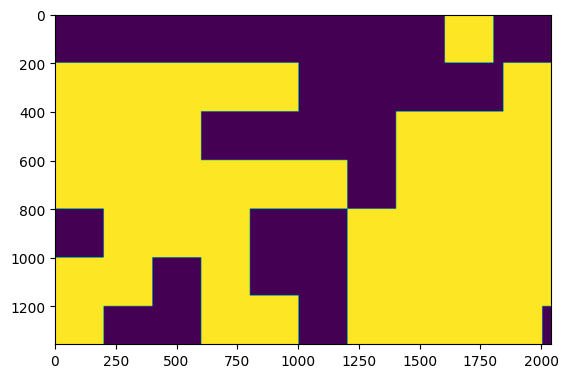

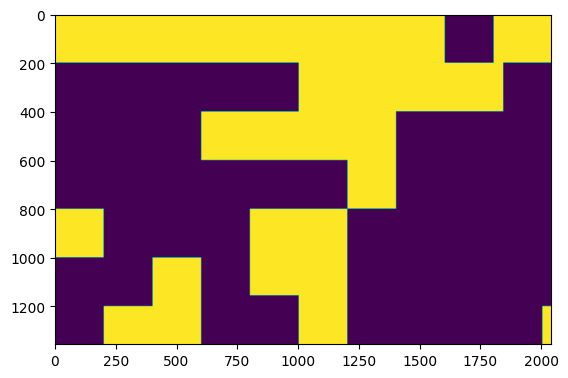

/content/drive/MyDrive/KernelGAN-Masks/imgs/img2
average_frequency_threshold =  5.581668047143984
max =  5.997973206894837
min =  5.155850088288188
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_lr_mask.png


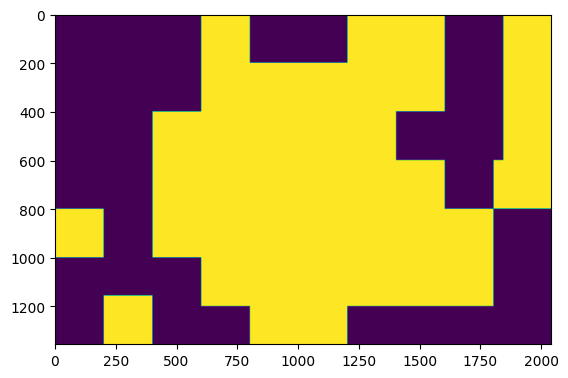

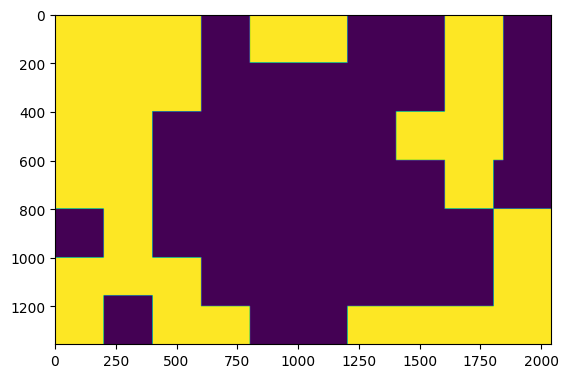

In [14]:
def create_mask(image_path):
    orig_img = cv2.imread(image_path)
    img = create_frequency_mask(image_path, 100)
    min_blob_size = 80
    img = remove_small_blobs(img, min_blob_size)
    img = cv2.bitwise_not(img)
    return img

base = "/content/drive/MyDrive/KernelGAN-Masks"
src = base + "/imgs"
dst = base + "/masks"

files = os.listdir(src)

for file_name in files:
    image_path = os.path.join(src, file_name)
    img_num = extract_numbers_from_filename(file_name)
    dir_path = os.path.join(dst, 'img' + str(img_num))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print(image_path)
    for img in os.listdir(image_path):
        if "lr" in img:
            image_path_lr = os.path.join(image_path, img)
            break
    lr_back = create_mask(image_path_lr)

    new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
    new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
    new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
    new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

    hr_back = cv2.resize(lr_back, dsize=[lr_back.shape[1]*2, lr_back.shape[0]*2], interpolation=cv2.INTER_CUBIC)
    hr_obj = cv2.bitwise_not(hr_back)
    lr_obj = cv2.bitwise_not(lr_back)

    cv2.imwrite(new_path_back_hr, hr_back)
    cv2.imwrite(new_path_back_lr, lr_back)
    cv2.imwrite(new_path_obj_hr, hr_obj)
    cv2.imwrite(new_path_obj_lr, lr_obj)

    print(new_path_back_hr)
    print(new_path_back_lr)
    print(new_path_obj_hr)
    print(new_path_obj_lr)

    plt.imshow(hr_obj)
    plt.show()
    plt.imshow(hr_back)
    plt.show()